<a href="https://colab.research.google.com/github/strongylocentrotus/BI-ML-2023/blob/neural_net/my_FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output


## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [13]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [31]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**
при маленьком батче небольшая стабильность, модель уязвима для шумов. 
при большом выше стабильность и сходимость

Посмотрим на какую-нибудь картинку:

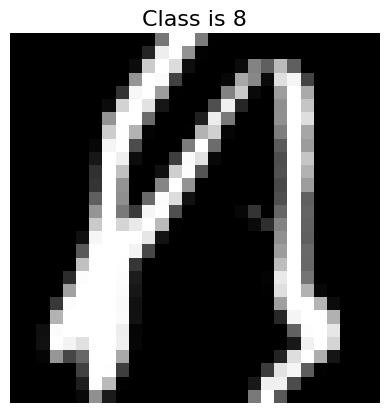

In [32]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





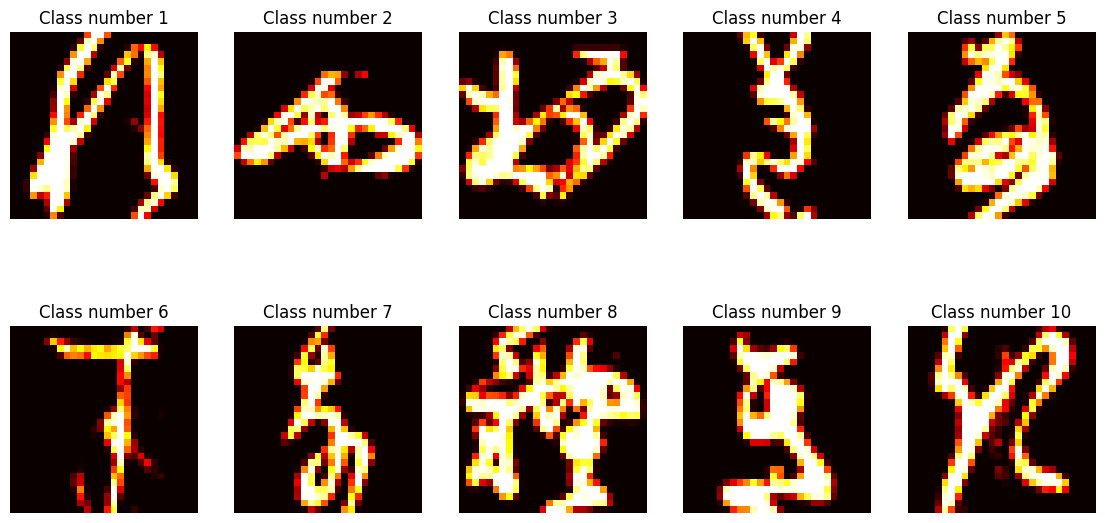

In [33]:
fig, block = plt.subplots(2, 5, figsize=(14, 7))

block = block.flatten()
for i in range(10):
    block[i].imshow(trainset[i][0].squeeze(), cmap="hot")
    block[i].set_title(f'Class number {i + 1}')
    block[i].axis('off')

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** 235146

In [18]:
(28 * 28 * 256 + 256) + 1290 + (256 * 128 + 128)

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [35]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [36]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [39]:
def epoch_fun(n_epochs: int, fc_class):
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_class(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


In [41]:
epoch_fun(10, fc_net)

Epoch=1 loss=0.9254
Epoch=2 loss=0.4414
Epoch=3 loss=0.3508
Epoch=4 loss=0.2956
Epoch=5 loss=0.2579
Epoch=6 loss=0.2253
Epoch=7 loss=0.1987
Epoch=8 loss=0.1763
Epoch=9 loss=0.1582
Epoch=10 loss=0.1387


In [43]:
get_accuracy(fc_net, testloader)

0.8733

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [45]:
mean = np.array([images.mean().item() for images, labels in trainloader]).mean()
std = np.array([images.std().item() for images, labels in trainloader]).std()
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.19174467115960223 0.0032809712820246507


In [46]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [47]:
## YOUR CODE HERE
epoch_fun(10, fc_net)

Epoch=1 loss=0.8457
Epoch=2 loss=0.2273
Epoch=3 loss=0.1269
Epoch=4 loss=0.0758
Epoch=5 loss=0.0463
Epoch=6 loss=0.0294
Epoch=7 loss=0.0214
Epoch=8 loss=0.0183
Epoch=9 loss=0.0162
Epoch=10 loss=0.0154


In [48]:
get_accuracy(fc_net, testloader)

0.8671

Как изменилась `accuracy` после нормализации?


незначительно, и не в лучшую сторону

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [49]:
## YOUR CODE HERE
class FCNet_sigmoid(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.fc3(x)

        return torch.sigmoid(x)


In [50]:
mean = np.array([images.mean().item() for images, labels in trainloader]).mean()
std = np.array([images.std().item() for images, labels in trainloader]).std()
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.008782902145956424 0.9821704345362067


In [51]:
fc_net_sigmoid = FCNet_sigmoid()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_sigmoid.parameters(), lr=lr)

In [53]:
epoch_fun(10, fc_net_sigmoid)


Epoch=1 loss=1.9369
Epoch=2 loss=1.6745
Epoch=3 loss=1.6083
Epoch=4 loss=1.5753
Epoch=5 loss=1.5549
Epoch=6 loss=1.5411
Epoch=7 loss=1.5303
Epoch=8 loss=1.5218
Epoch=9 loss=1.5149
Epoch=10 loss=1.5089


In [55]:
get_accuracy(fc_net_sigmoid, testloader)

0.8529

In [56]:
class FCNet_gelu(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.fc3(x)

        return F.gelu(x)

In [57]:
fc_net_gelu = FCNet_gelu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_gelu.parameters(), lr=lr)

In [58]:
epoch_fun(10, fc_net_gelu)

Epoch=1 loss=0.6756
Epoch=2 loss=0.3425
Epoch=3 loss=0.2556
Epoch=4 loss=0.2055
Epoch=5 loss=0.1710
Epoch=6 loss=0.1453
Epoch=7 loss=0.1276
Epoch=8 loss=0.0634
Epoch=9 loss=0.0409
Epoch=10 loss=0.0321


In [82]:
get_accuracy(fc_net_gelu, testloader)

0.9075

In [60]:
class FCNet_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):
        x = x.view(-1, 28*28) 
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)

        return F.tanh(x)

In [78]:
fc_net_tanh = FCNet_tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_tanh.parameters(), lr=lr)

In [79]:
epoch_fun(10, fc_net_tanh)

Epoch=1 loss=1.2029
Epoch=2 loss=0.9923
Epoch=3 loss=0.9325
Epoch=4 loss=0.8987
Epoch=5 loss=0.8759
Epoch=6 loss=0.8594
Epoch=7 loss=0.8479
Epoch=8 loss=0.8394
Epoch=9 loss=0.8325
Epoch=10 loss=0.8290


In [83]:
get_accuracy(fc_net_tanh, testloader)

0.8997

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Пока получается, что для gelu. Но я не перезапускала по сто раз

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [89]:
fc_net_gelu = FCNet_gelu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_gelu.parameters(), lr=lr)

In [90]:
epoch_fun(10, fc_net_gelu)

Epoch=1 loss=0.6616
Epoch=2 loss=0.3336
Epoch=3 loss=0.2501
Epoch=4 loss=0.2017
Epoch=5 loss=0.1676
Epoch=6 loss=0.1441
Epoch=7 loss=0.1243
Epoch=8 loss=0.1116
Epoch=9 loss=0.1010
Epoch=10 loss=0.0932


In [91]:
get_accuracy(fc_net_gelu, testloader)

0.8509

In [92]:
fc_net_gelu = FCNet_gelu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net_gelu.parameters(), lr=lr)

In [93]:
epoch_fun(10, fc_net_gelu)

Epoch=1 loss=0.5093
Epoch=2 loss=0.2134
Epoch=3 loss=0.1422
Epoch=4 loss=0.1029
Epoch=5 loss=0.0732
Epoch=6 loss=0.0534
Epoch=7 loss=0.0383
Epoch=8 loss=0.0280
Epoch=9 loss=0.0213
Epoch=10 loss=0.0180


In [94]:
get_accuracy(fc_net_gelu, testloader)

0.9069

In [95]:
fc_net_gelu = FCNet_gelu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net_gelu.parameters(), lr=lr)

In [96]:
epoch_fun(10, fc_net_gelu)

Epoch=1 loss=1.0201
Epoch=2 loss=0.7143
Epoch=3 loss=0.6520
Epoch=4 loss=0.6160
Epoch=5 loss=0.5909
Epoch=6 loss=0.5712
Epoch=7 loss=0.5549
Epoch=8 loss=0.5402
Epoch=9 loss=0.5288
Epoch=10 loss=0.5177


In [97]:
get_accuracy(fc_net_gelu, testloader)

0.6949

ну 0,69 это конечно грустно, а RMSprop молодец

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [84]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [85]:
class FCNet_relu(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)

        return nn.ReLU()(x)

In [86]:
fc_net_relu = FCNet_relu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_relu.parameters(), lr=lr)

In [87]:
epoch_fun(10, fc_net_relu)

Epoch=1 loss=1.0749
Epoch=2 loss=0.7776
Epoch=3 loss=0.6813
Epoch=4 loss=0.5862
Epoch=5 loss=0.5570
Epoch=6 loss=0.5346
Epoch=7 loss=0.5206
Epoch=8 loss=0.5070
Epoch=9 loss=0.5014
Epoch=10 loss=0.4915


In [88]:
get_accuracy(fc_net_relu, testloader)

0.7307

In [98]:
class FCNet_cust_relu(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)



    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = CustomReLU()(x)
        x = self.fc2(x)
        x = CustomReLU()(x)
        x = self.fc3(x)

        return CustomReLU()(x)

In [99]:
fc_net_cust_relu = FCNet_cust_relu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_cust_relu.parameters(), lr=lr)


In [102]:
epoch_fun(10, fc_net_cust_relu)

Epoch=1 loss=0.7243
Epoch=2 loss=0.7207
Epoch=3 loss=0.7206
Epoch=4 loss=0.7152
Epoch=5 loss=0.7128
Epoch=6 loss=0.7153
Epoch=7 loss=0.7136
Epoch=8 loss=0.7191
Epoch=9 loss=0.7140
Epoch=10 loss=0.7110


In [103]:
get_accuracy(fc_net_cust_relu, testloader)

0.7254

ага, незначительны перемены

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

**первокурсники убивают желтых как солнце улиток на кровожадной практике по зоологии беспозвоночных**

ни тебе студентов, ни солнца, ни улиток. тьфу.

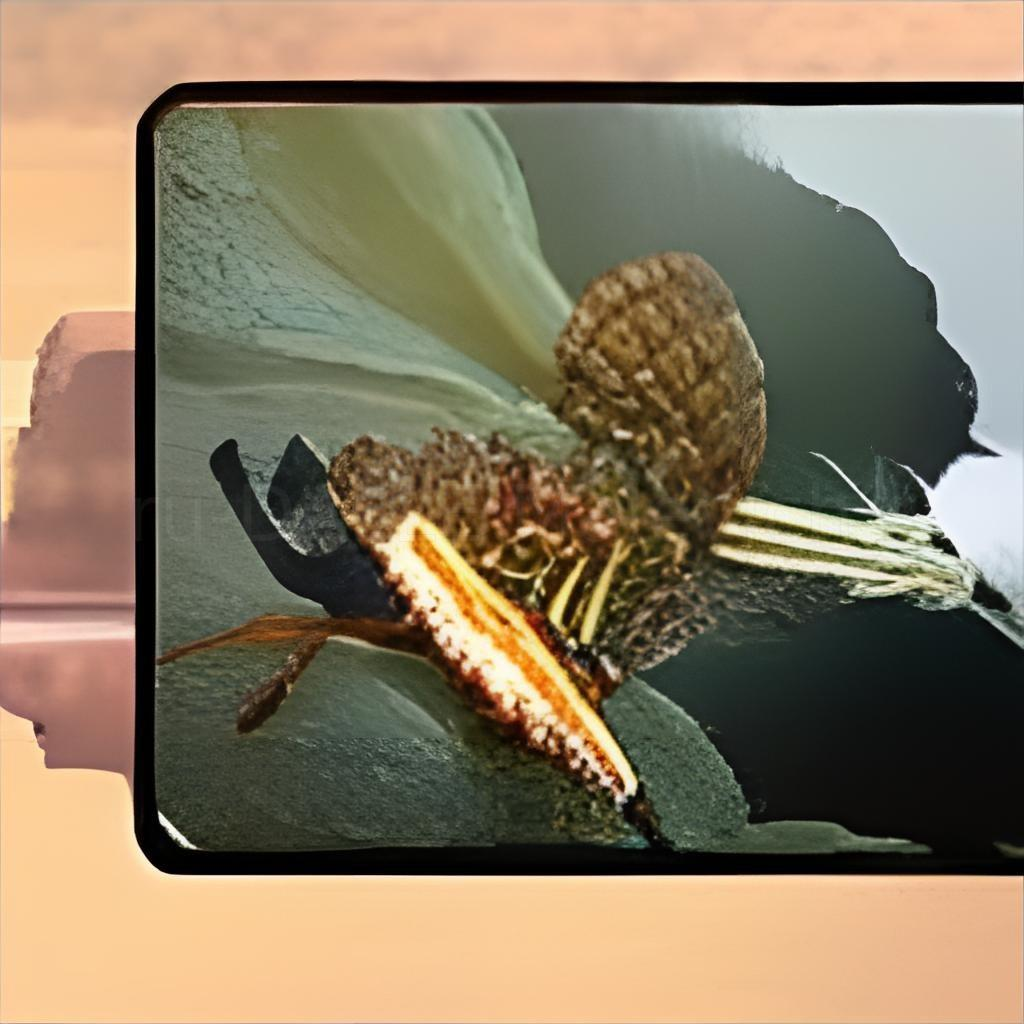

In [ ]:
from IPython import display
display.Image('snails.jpg')

**мама мыла раму**

ну здесь все честно, присутствует и мама, и мыло, и видимо картины в рамках

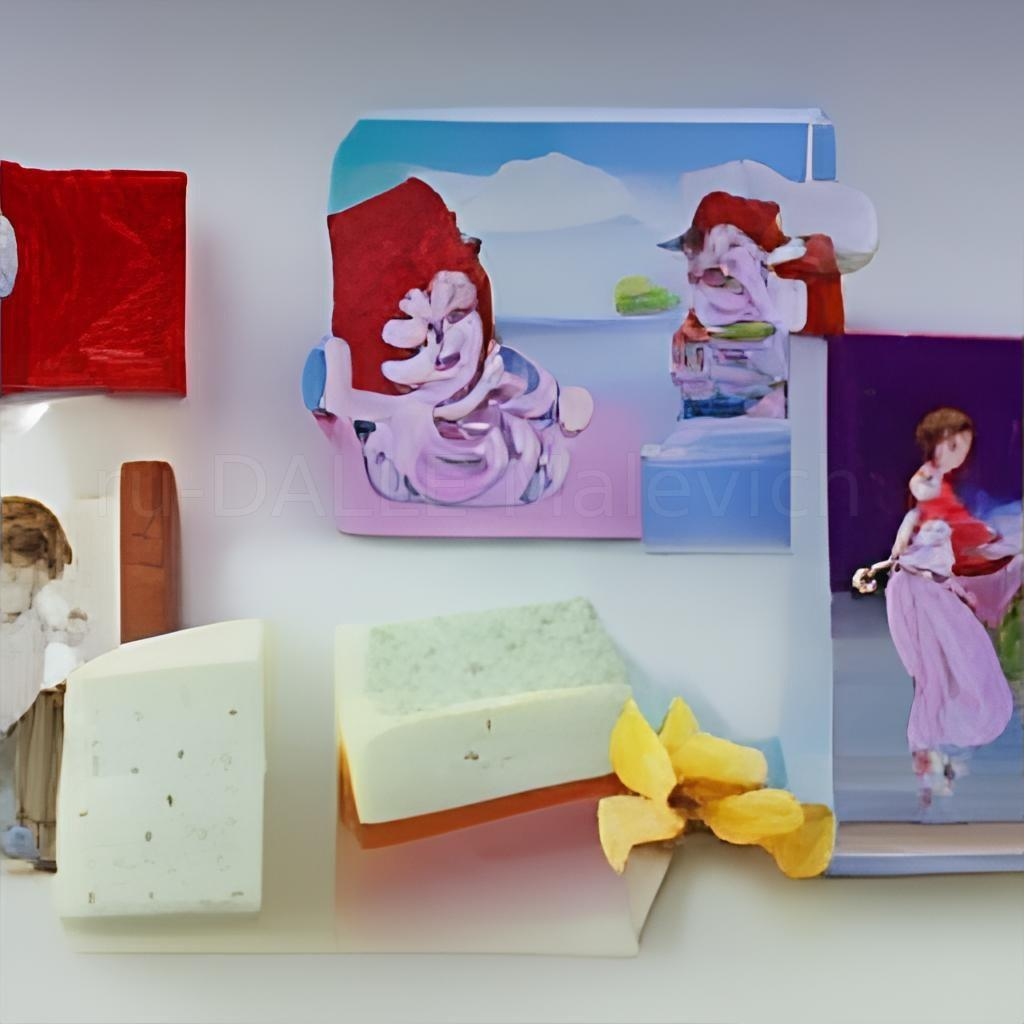

In [ ]:
from IPython import display
display.Image('mother.jpg')

**эгон шиле нарисовал меня**
не попал по стилю даже кмк

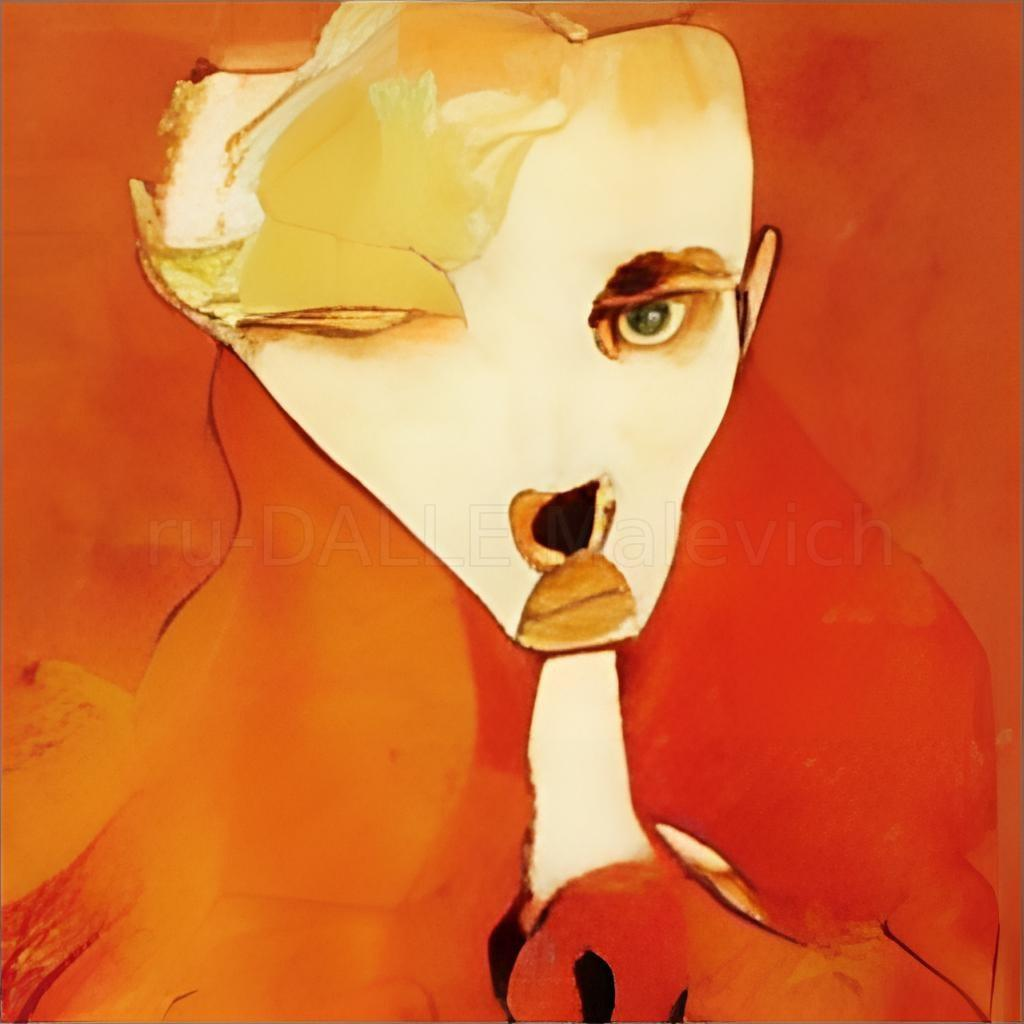

In [ ]:
from IPython import display
display.Image('schile.jpg')